In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv


In [2]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
import random

Let's see data

In [3]:
data = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')

In [4]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [5]:
meantemp_data = data[['date', 'meantemp']]
meantemp_data['date'] = pd.to_datetime(meantemp_data['date'])

In [6]:
meantemp_data['days'] = meantemp_data['date'] - meantemp_data['date'].min()

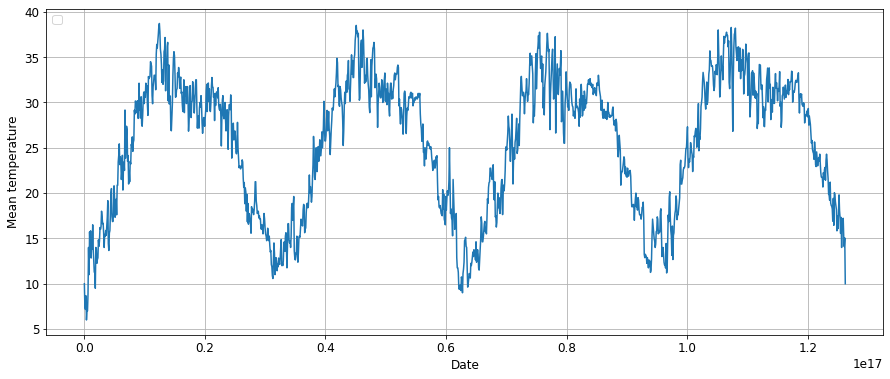

In [7]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(meantemp_data.days, meantemp_data.meantemp)

ax.set_xlabel('Date')
ax.set_ylabel('Mean temperature')
ax.grid(True)
ax.legend(loc='upper left');

As you can see, the data has a certain seasonality. We can clearly trace how the value of a variable changes over the course of a year

So, let's add some outliers

In [8]:
meantemp_data_noised = meantemp_data.copy()

for i in range(20):
    outlier = random.randint(0, meantemp_data.shape[0])
    meantemp_data_noised.at[outlier, 'meantemp'] = meantemp_data.loc[outlier].meantemp + (15 if random.random() < 0.5 else -15)

Here we can see the data with added outliers

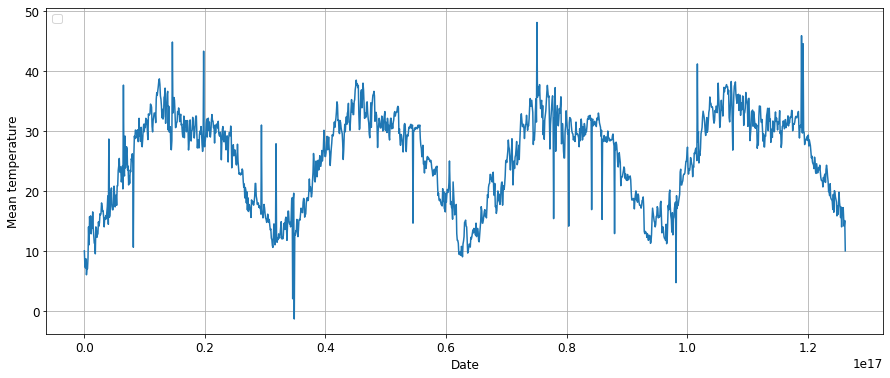

In [9]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(meantemp_data_noised.days, meantemp_data_noised.meantemp)

ax.set_xlabel('Date')
ax.set_ylabel('Mean temperature')
ax.grid(True)
ax.legend(loc='upper left');

The STL method uses LOESS, so let's see how LOESS fits data

In [10]:
lowess = sm.nonparametric.lowess(meantemp_data_noised.meantemp, meantemp_data_noised.days, frac=.1)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

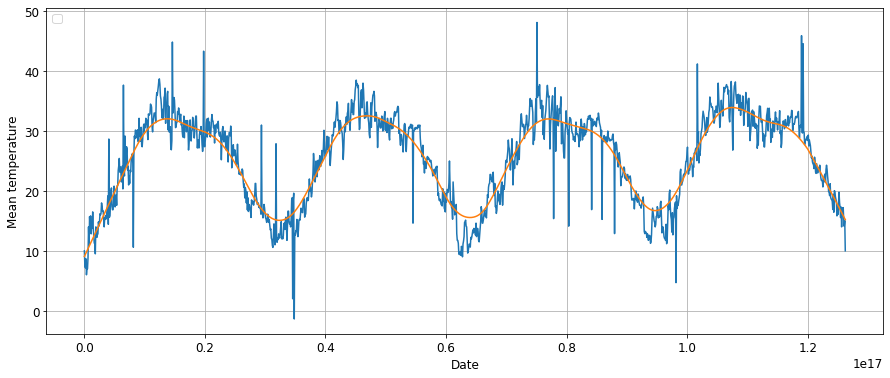

In [11]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(meantemp_data_noised.days, meantemp_data_noised.meantemp)
plt.plot(lowess_x, lowess_y)

ax.set_xlabel('Date')
ax.set_ylabel('Mean temperature')
ax.grid(True)
ax.legend(loc='upper left');

Here we decompose our time series using STL

In [12]:
stl = STL(meantemp_data_noised['meantemp'].to_numpy(), period = 365)
result = stl.fit()

In [13]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

cleaned_data = seasonal + trend

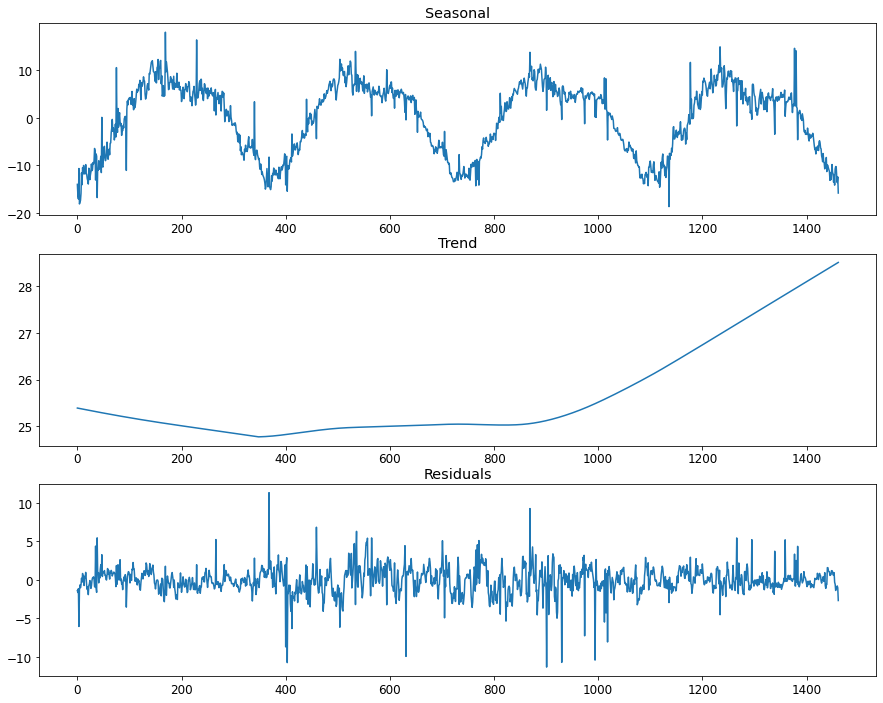

In [14]:
plt.figure(figsize = (15, 12))

plt.subplot(3,1,1)
plt.plot(seasonal)
plt.title('Seasonal')

plt.subplot(3,1,2)
plt.plot(trend)
plt.title('Trend')

plt.subplot(3,1,3)
plt.plot(resid)
plt.title('Residuals')

plt.show()

So, the main idea of using STL in anomaly detection is to calculate the mean and standard deviation of the Residuals component of the STL decomposition and exclude all point for which residuals differs from the average by more than 4 (for example) std's 

In [15]:
res_mean = resid.mean()
resid_std = resid.std()

lower_bound = res_mean - 4*resid_std
upper_bound = res_mean + 4*resid_std

All points that lie beyond the green zone are considered anomalies

Text(0, 0.5, 'Mean temperature')

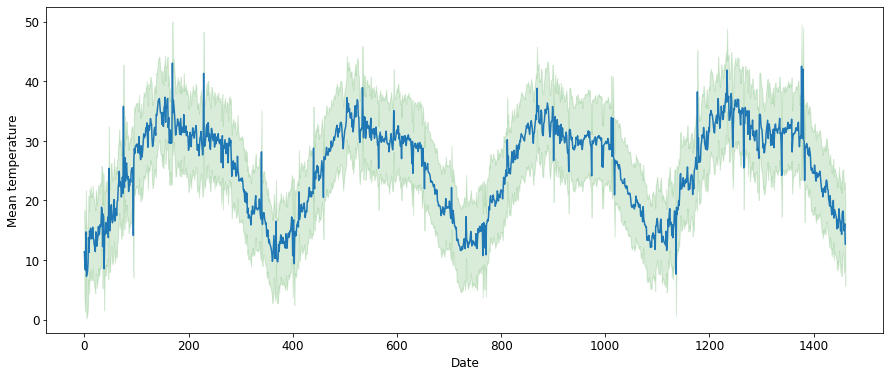

In [16]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(cleaned_data)
plt.fill_between(list(range(1462)), cleaned_data - lower_bound, cleaned_data + lower_bound, color = 'g', alpha = 0.15)

ax.set_xlabel('Date')
ax.set_ylabel('Mean temperature')

In [17]:
anomalies = meantemp_data_noised[(resid < lower_bound) | (resid > upper_bound)]

Below you can see all the points that we consider anomalies. Even though the algorithm is pretty good, we didn't find all the outliers.

In [18]:
anomalies[['date', 'meantemp']].rename(columns={'meantemp': 'anomaly_value'}).join(
    meantemp_data[(resid < lower_bound) | (resid > upper_bound)][['date', 'meantemp']].set_index('date'),
    on = 'date'
)

,date,anomaly_value,meantemp
368,2014-01-04,27.875,12.875
400,2014-02-05,2.000,17.000
403,2014-02-08,-1.375,13.625
631,2014-09-24,14.625,29.625
869,2015-05-20,48.125,33.125
901,2015-06-21,15.375,30.375
930,2015-07-20,14.125,29.125
974,2015-09-02,16.875,31.875
994,2015-09-22,15.250,30.250
1018,2015-10-16,12.875,27.875
